In [62]:
import numpy as np
import re
from numpy.linalg import inv

import torch
import torch.nn as nn
import torch.nn.functional as F

# print(im)

batch_size, n_classes = 10, 1
x = torch.randn(batch_size, n_classes)
# print(x)
x.shape
target = (torch.rand(batch_size, dtype=torch.float) > 0.5).float()
y=target.reshape(-1,1)
# print(x)
# print(y)
# L_corrected(y_obs, p) = -Σ_i (T_inv[i, y_obs] * log(p_i))
# im = torch.inverse(torch.tensor([[1.0,0.0],[0.8,0.2]]))
im = torch.tensor(np.array([[1.0,0.0],[0.8,0.2]]), requires_grad=False)#to(self.device)

def binary_cross_entropy_corrected(pred, y, im=im): 
    #im = inverted matrix
    pred = torch.sigmoid(pred).flatten()
    batch_size = y.size()[0]
    y = y.long().flatten()
    #TODO check 1d tensor * 1d tensor is 1d tensor
    # print(im[np.ones(batch_size, dtype=np.int32),y])
    pos_part = pred.log()*im[np.ones(batch_size, dtype=np.int32),y]#y
    print(pred.log())
    print(im[np.ones(batch_size, dtype=np.int32),y])
    print(pred.log()*im[np.ones(batch_size, dtype=np.int32),y])
    neg_part = (1-pred).log()*im[np.zeros(batch_size, dtype=np.int32),y]#(1-y)
    # print(neg_part)
    loss = -(pos_part + neg_part)
    loss = torch.clamp(loss, min=-100, max=100)
    return loss.mean()
    
pred = torch.sigmoid(x)
loss = binary_cross_entropy_corrected(pred, y, im=im)

# print(pred.size())
# print(y.size())
print('LOSSES')
print(loss)

# F.binary_cross_entropy_with_logits(x, y)


tensor([-0.3537, -0.5485, -0.4866, -0.4659, -0.3930, -0.5691, -0.5230, -0.4910,
        -0.5030, -0.4011])
tensor([0.8000, 0.2000, 0.8000, 0.8000, 0.8000, 0.2000, 0.2000, 0.8000, 0.8000,
        0.8000], dtype=torch.float64)
tensor([-0.2830, -0.1097, -0.3893, -0.3727, -0.3144, -0.1138, -0.1046, -0.3928,
        -0.4024, -0.3209], dtype=torch.float64)
LOSSES
tensor(1.0062, dtype=torch.float64)


In [103]:
import torch
import torch.nn as nn
# nx = torch.sigmoid(x)

T = torch.tensor([[1.0, 0.0],
                  [0.8, 0.2]])
def binary_cross_entropy_corrected(pred, y): 
    pred = torch.sigmoid(pred)
    y = y.flatten()
    y_true = torch.stack([1-y,y]).permute(1,0)
    y_pred = torch.stack([1-pred, pred]).squeeze().permute(1,0)
    uncorrected_losses = F.binary_cross_entropy(y_pred, y_true, reduction='none')
    losses_corrected = torch.matmul(T, uncorrected_losses.T).T
    corrected_loss = losses_corrected.mean()
    return corrected_loss

binary_cross_entropy_corrected(x,y)

tensor(1.0476)

In [75]:
print(im)
im[np.array(np.ones(2, dtype=np.int32)),np.array([0,1])]


[[ 1.  0.]
 [-4.  5.]]


array([-4.,  5.])

# Interpretability

In [1]:
from rnamodif.architectures.rodan_seq import RodanPretrainedSeqcaller

architecture = RodanPretrainedSeqcaller
checkpoint = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/Mixed_seqcaller_weighted_pos2_dropout_max/last.ckpt'
model = architecture().load_from_checkpoint(checkpoint)
pass

REDOING MISH IN RODAN.model code to fix deepshap error
using weighted loss
tensor([0.1000, 0.2000, 0.2000, 0.2000, 0.2000])
using weighted loss
tensor([0.1000, 0.2000, 0.2000, 0.2000, 0.2000])


In [2]:
from taiyaki.mapped_signal_files import HDF5Reader
import random
hdf5_reader_path = '/home/jovyan/taiyaki_test/mapped_reads_2/m6A_33'
# '/home/jovyan/taiyaki_test/mapped_reads_2/m6A_0'
reader = HDF5Reader(hdf5_reader_path)
nums = reader.get_alphabet_information().collapse_labels
letters = list(reader.get_alphabet_information().collapse_alphabet)
vocab_map = {x:y for (x,y) in zip(letters,nums)}
vocab_map_reversed = {v:k for k,v in vocab_map.items()}
available_batch_names = reader.batch_names
new_batch_name = available_batch_names[0]
reads_batch = reader._load_reads_batch(new_batch_name)


In [92]:
import numpy as np
from matplotlib import pyplot as plt
import torch
def process_signal_mapping(mapping):
    #Taken from RODAN code, replace with native mapping function
    signal = (mapping.Dacs + mapping.offset) * mapping.range / mapping.digitisation

    med = np.median(signal)
    mad = mapping.offset * np.median(abs(signal-med))
    signal = (signal - mapping.shift_frompA) / mapping.scale_frompA
    return signal

def get_sample(mapping, window=4096, shift=100):
    signal = process_signal_mapping(mapping)
    start = window*shift
    end = window*(shift+1)
    window_positions = (start,end)
    ref_beg, ref_end = np.searchsorted(mapping.Ref_to_signal, window_positions)
    bases_count  = ref_end-ref_beg
    window_ref = mapping.Reference[ref_beg:ref_end]
    event = signal[start:end]
    sequence = [vocab_map_reversed[index] for index in window_ref]
     #TODO Add quality control (n_bases > 20 etc..)   
    tensor_out = torch.tensor(event).reshape(1,1,-1).float()
    
    
    return tensor_out, mapping.Ref_to_signal[ref_beg:ref_end], sequence, start

In [4]:
from rnamodif.data_utils.dataloading2 import nanopore_datamodule
from rnamodif.data_utils.split_methods import get_kfold_splits, get_fullvalid_split, get_valid_portions
dm = nanopore_datamodule(
    splits = get_kfold_splits(
        pos_exps=['m6A_33_covid', 's4U_33_covid', 'ac4C_33_covid', 'remdesivir_33_covid'],
        neg_exps=['m6A_0_covid', 's4U_0_covid', 'ac4C_0_covid', 'remdesivir_0_covid'], 
        total_k=5, 
        current_k=0
    )
    +get_fullvalid_split()(pos_files=['m6A_5_covid','m6A_10_covid', 's4U_5_covid', 's4U_10_covid', 'ac4C_10_covid', 'remdesivir_5_covid'], neg_files=[]),
    verbose=1, 
    batch_size=64, 
    valid_limit=5000, 
    workers=3,
    window=4096,
    normalization='rodan',
)
dm.setup()
val_dl = dm.train_dataloader()
random_Xs,y,exp = next(iter(val_dl))
randomXs = random_Xs.detach().cpu()


temporary using iterable generator for valid


Traceback (most recent call last):


In [21]:
X, rts, seq, start = get_sample(random.choice(list(reads_batch.values())))


In [18]:
import shap
import torch
from RODAN.model import Mish

#RODAN sets it to FALSE when model loading
#TODO put into my code too????
# background = torch.randn(64, 1, 4096) #TODO should be random sequences?
background = random_Xs

torch.set_grad_enabled(True)
model.cuda()
X.cuda()
explainer = shap.DeepExplainer(model, background.cuda())


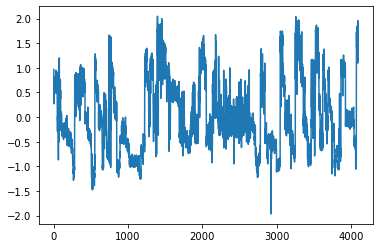

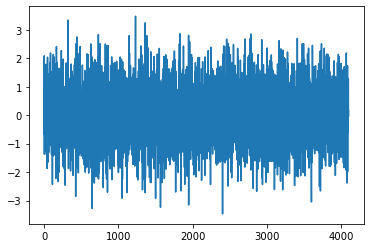

In [22]:
from matplotlib import pyplot as plt

plt.plot(X[0,0,:])
plt.show()
plt.plot(background[0,0,:].cpu())

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


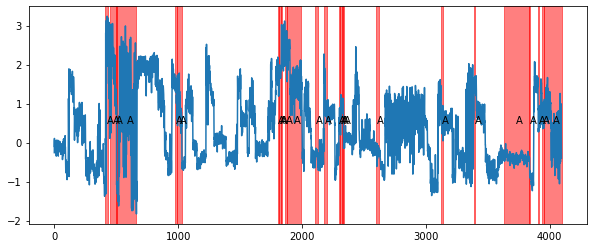

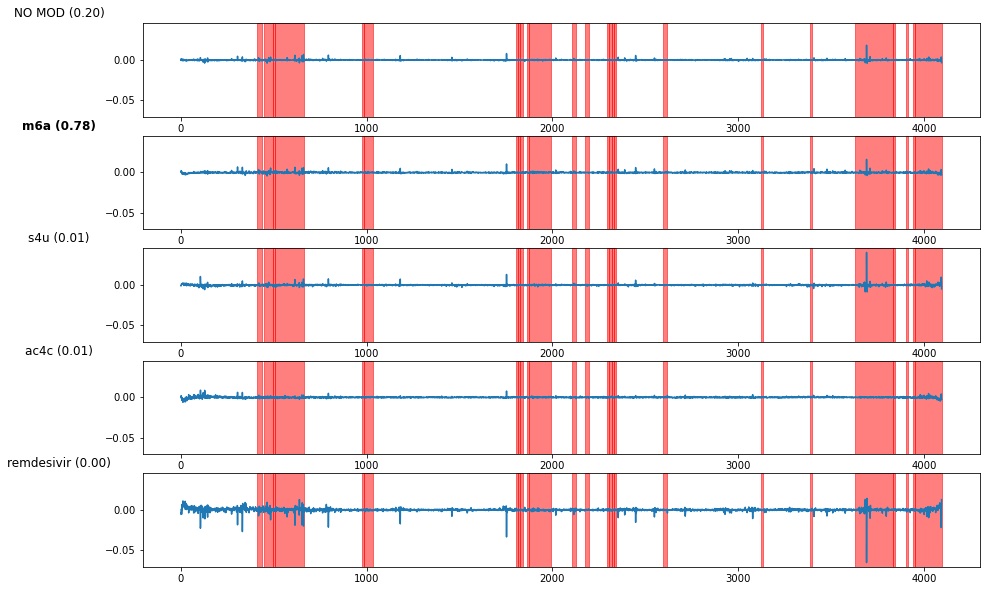

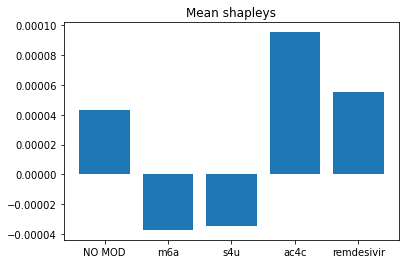

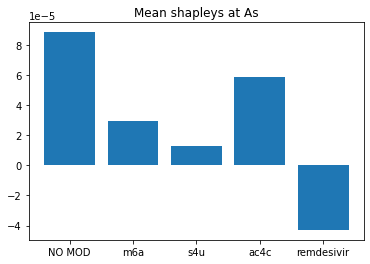

In [130]:
X, rts, seq, start = get_sample(random.choice(list(reads_batch.values())), shift=10)
shap_values = explainer.shap_values(X)

label_map = {0:'NO MOD', 1:'m6a', 2:'s4u', 3:'ac4c', 4:'remdesivir'}
sample = 0
max_label = torch.argmax(torch.softmax(model(X.cuda()), dim=-1)).cpu().detach().numpy()

preds = torch.softmax(model(X.cuda()), dim=-1).flatten().cpu().detach().numpy()
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(X[sample][0].numpy())

cutoffs = rts-start
for i, cutoff in enumerate(cutoffs):
    if(seq[i] == 'A'):
        if(i+1 >= len(cutoffs)):
            end_index = len(X[sample][0].numpy())
        else:
            end_index = cutoffs[i+1]
        ax.axvspan(cutoff, end_index , alpha=0.5, color='red')
        ax.text(cutoff+(end_index-cutoff)/2, 0.5, seq[i], fontsize=10)
plt.show()


fig, axs = plt.subplots(len(shap_values),1, sharey=True, figsize=(15,10))
mean_shapleys = []
mean_shapleys_at_As = {k:[] for k in label_map.keys()}
for label in range(len(shap_values)):
    title = axs[label].set_title(f'{label_map[label]} ({preds[label]:.2f})')
    title.set_position([-0.1, 1])
    if(label == max_label):
        title.set_weight('bold')
    axs[label].plot(shap_values[label][sample][0])
    
    mean_shapleys.append(np.mean(shap_values[label][sample][0]))
    
    
    for i, cutoff in enumerate(cutoffs):
        if(seq[i] == 'A'):
            if(i+1 >= len(cutoffs)):
                end_index = len(X[sample][0].numpy())
            else:
                end_index = cutoffs[i+1]
            axs[label].axvspan(cutoff, end_index , alpha=0.5, color='red')
            for val in shap_values[label][sample][0][cutoff:end_index]:
                mean_shapleys_at_As[label].append(val)
            # mean_shapleys_at_As[label].append(*shap_values[label][sample][0][cutoff:end_index])
            
for k,v in mean_shapleys_at_As.items():
    mean_shapleys_at_As[k] = np.mean(v)

# print(seq)

fig.show()
fig, ax = plt.subplots()
ax.set_title('Mean shapleys')
ax.bar(label_map.values(), mean_shapleys)
fig.show()
fig, ax = plt.subplots()
ax.set_title('Mean shapleys at As')
ax.bar(label_map.values(), mean_shapleys_at_As.values())
fig.show()

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


tensor([[ 3.8933,  5.7554,  0.5759, -0.9551,  0.6959]], device='cuda:0',
       grad_fn=<MaxBackward0>)
tensor([[0.1329, 0.8558, 0.0048, 0.0010, 0.0054]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.9753, 1.7146, 2.0484, 1.4545, 0.7123]], device='cuda:0',
       grad_fn=<MaxBackward0>)
tensor([[0.2686, 0.2069, 0.2889, 0.1595, 0.0760]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


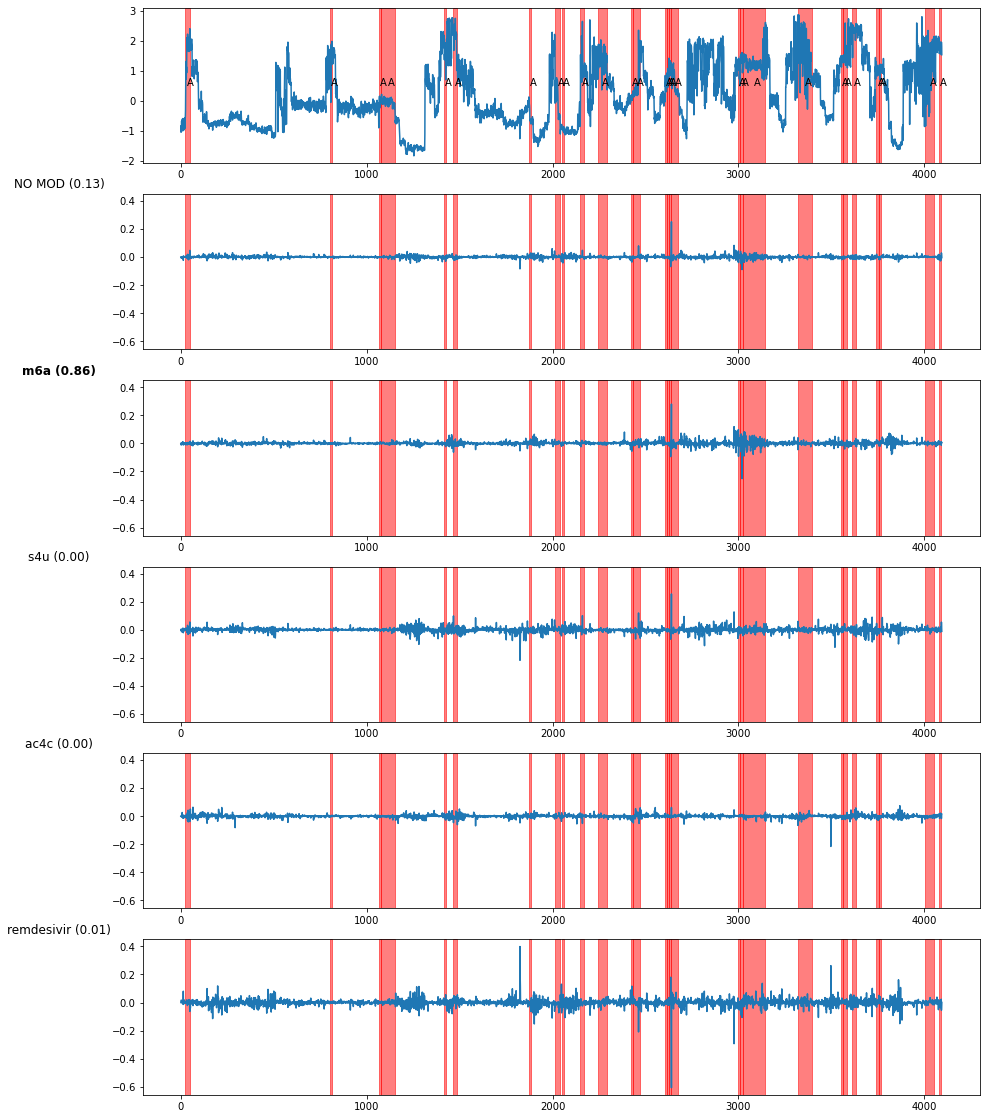

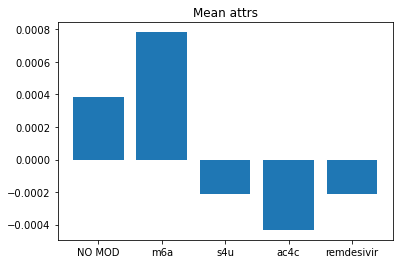

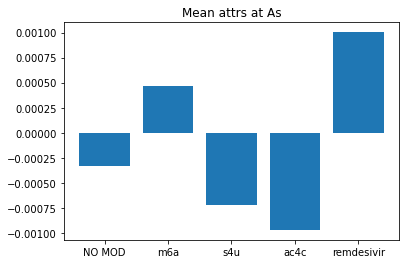

In [135]:
from captum.attr import IntegratedGradients
model.cuda()
label_map = {0:'NO MOD', 1:'m6a', 2:'s4u', 3:'ac4c', 4:'remdesivir'}
X, rts, seq, start = get_sample(random.choice(list(reads_batch.values())), shift=5)
ig_explainer = IntegratedGradients(model)
# torch.tensor([0,1,0,0,0]).float().cuda().reshape(1,-1)
fig, ax = plt.subplots(6, figsize=(15,20))
sample=0
ax[0].plot(X[sample][0].numpy())
baseline = torch.randn(1,4096).cuda() #TODO try zeros?
# baseline = torch.zeros(1,4096).cuda() 

preds = torch.softmax(model(X.cuda()), dim=-1).flatten().cpu().detach().numpy()
print(model(X.cuda()))
print(torch.softmax(model(X.cuda()), dim=-1))

print(model(baseline.reshape(1,1,4096).cuda()))
print(torch.softmax(model(baseline.reshape(1,1,4096).cuda()), dim=-1))


max_label = torch.argmax(torch.softmax(model(X.cuda()), dim=-1)).cpu().detach().numpy()
mean_attrs = []
mean_attrs_at_As = {k:[] for k in label_map.keys()}

for target in label_map.keys():
    attrs = ig_explainer.attribute(X.cuda(),baselines=baseline, target=target, n_steps=150) #is m6a modified = target = 1
    ax[target+1].plot(attrs.flatten().detach().cpu())
    mean_attrs.append(torch.mean(attrs.detach().cpu().flatten()).item())
    cutoffs = rts-start
    for i, cutoff in enumerate(cutoffs):
        if(seq[i] == 'A'):
            if(i+1 >= len(cutoffs)):
                end_index = len(X[sample][0].numpy())
            else:
                end_index = cutoffs[i+1]
            if(target==0):
                ax[0].axvspan(cutoff, end_index , alpha=0.5, color='red')
                ax[0].text(cutoff+(end_index-cutoff)/2, 0.5, seq[i], fontsize=10)
            ax[target+1].axvspan(cutoff, end_index , alpha=0.5, color='red')
            
            title = ax[target+1].set_title(f'{label_map[target]} ({preds[target]:.2f})')
            title.set_position([-0.1, 1])
            if(target == max_label):
                title.set_weight('bold')
            for val in attrs.detach().cpu().flatten()[cutoff:end_index]:
                mean_attrs_at_As[target].append(val.item())

for a in ax[2:].flatten():
    a.sharey(ax[1])

fig.show()
fig, ax = plt.subplots()
ax.set_title('Mean attrs')
ax.bar(label_map.values(), mean_attrs)
fig.show()

for k,v in mean_attrs_at_As.items():
    mean_attrs_at_As[k] = np.mean(v)
fig, ax = plt.subplots()
ax.set_title('Mean attrs at As')
ax.bar(label_map.values(), mean_attrs_at_As.values())
fig.show()

In [ ]:
# class Mish(nn.Module):
    # def __init__(self):
        # super().__init__()
    # def forward(self, x):
        # return x *( torch.tanh(torch.nn.functional.softplus(x)))

# NEEDED CHANGE FOR THE SHAP VALUE EXPLAINER
# def Mish():
#     def f(x):
#         return x *( torch.tanh(torch.nn.functional.softplus(x)))
#     return f